In [13]:
from pm4py.visualization.dfg import visualizer as dfg_visualizer

# (auto-reload changes from imported libraries)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
sys.path.append("..")
from modules.cmp_logs import dicts_to_dfgs, compare_dfgs, GroupTypes, print_cmp_results
from modules.utils import read_dict

def compare_by_log(dicts, labels):
    dfgs = dicts_to_dfgs(dicts)
    
    # construct DFG for each sublog & get comparison results
    cmp_results = compare_dfgs(dfgs)

    # print the comparison results in a "human-readable" format
    print("-- compare by log\n")
    print_cmp_results(cmp_results, labels, group_type=GroupTypes.BY_LOG)

# Compare Two Mined Processes

{('In Progress - Assessor Reviewing', 'In Progress - Assigned'): 1, ('In Progress - Assigned', 'Completed - Assessment Complete'): 1, ('In Progress - Letter - Defer', 'New - Received'): 1, ('In Progress - Letter - Defer', 'On Hold (Pending) - Await Applicant'): 1, ('Medical Exam Date', 'New - Create File'): 47, ('Medical Exam Date', 'New - Received'): 3, ('Medical Exam Date', 'Received Date'): 37, ('New - Create File', 'New - Received'): 83, ('New - For AMO/RAMO', 'Completed - Assessment Complete'): 1, ('New - Received', 'Completed - Assessment Complete'): 84, ('New - Received', 'In Progress - Assessor Reviewing'): 1, ('New - Received', 'In Progress - Letter - Defer'): 2, ('New - Received', 'New - For AMO/RAMO'): 1, ('Received Date', 'Medical Exam Date'): 50, ('Received Date', 'New - Create File'): 36, ('Received Date', 'New - Received'): 1}


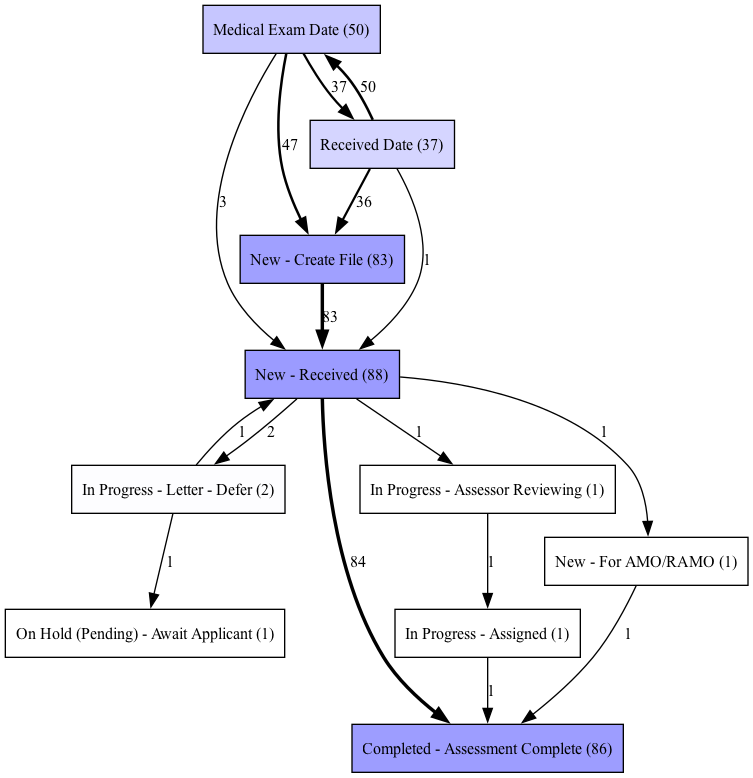

In [15]:
dfg1 = read_dict('./data/Event Dictionaries/PMed_Reallocation_New1_Event Dictionary.py')
print(dfg1)
dfg_visualizer.view(dfg_visualizer.apply(dfg1))

{('completed - assessment complete', 'in progress - letter - defer'): 1, ('completed - assessment complete', 'in progress - letter - fit'): 1, ('in progress - assessor reviewing', 'completed - assessment complete'): 3, ('in progress - assessor reviewing', 'on hold (pending) - await applicant'): 2, ('in progress - assigned', 'new - for amo/ramo'): 1, ('in progress - for follow-up review', 'completed - assessment complete'): 2, ('in progress - for follow-up review', 'in progress - letter - defer'): 1, ('in progress - letter - defer', 'completed - assessment complete'): 2, ('in progress - letter - defer', 'on hold (pending) - await applicant'): 24, ('in progress - letter - fit', 'completed - assessment complete'): 3, ('in progress - letter - fit', 'on hold (pending) - await applicant'): 1, ('medical exam date', 'new - create file'): 188, ('medical exam date', 'new - received'): 4, ('new - create file', 'new - received'): 416, ('new - for amo/ramo', 'completed - assessment complete'): 71, 

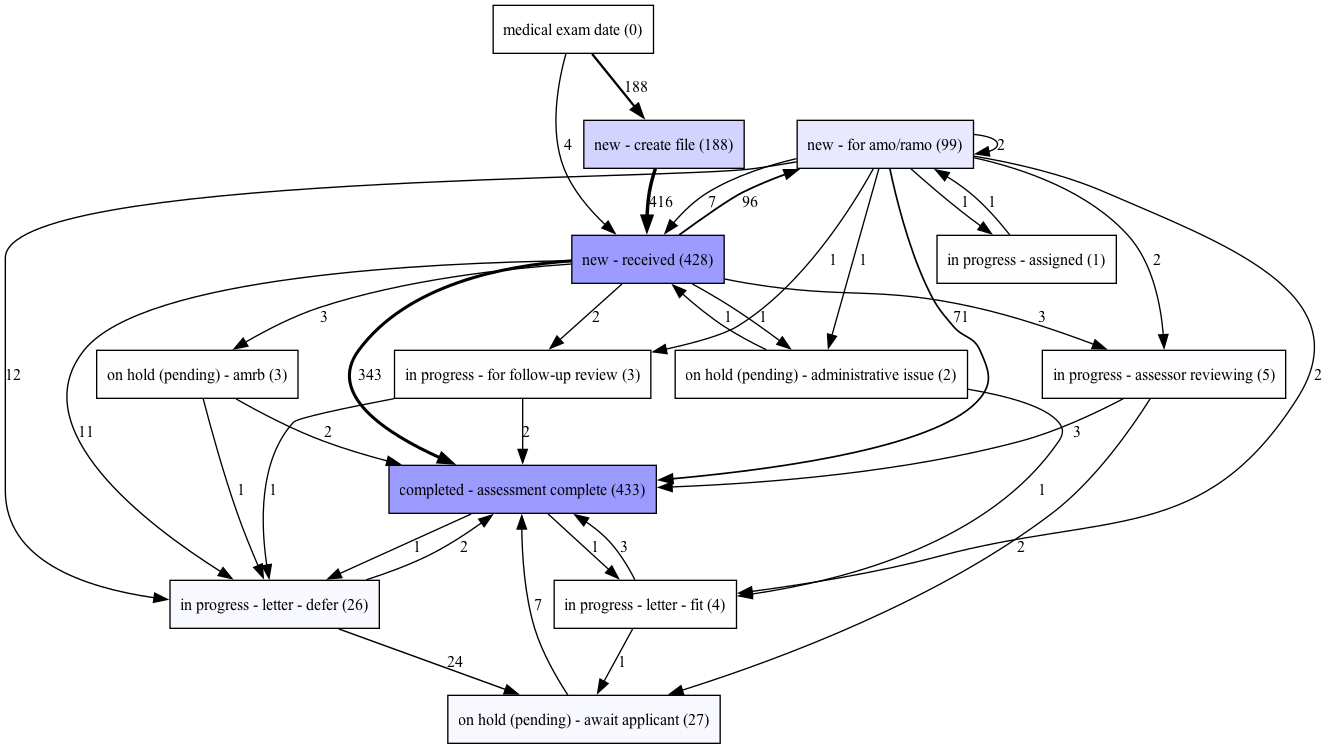

In [16]:
dfg2 = read_dict('./data/Event Dictionaries/PMed_Reallocation_New2_Event Dictionary.py')
print(dfg2)
dfg_visualizer.view(dfg_visualizer.apply(dfg2))

In [17]:
compare_by_log([ dfg1, dfg2 ], [ 'New for Period I', 'New for Period II' ])

-- compare by log

> log New for Period I
- compared to log New for Period II:
. extra events: In Progress - Assigned, New - Create File, In Progress - Letter - Defer, Completed - Assessment Complete, New - Received, New - For AMO/RAMO, Medical Exam Date, Received Date, On Hold (Pending) - Await Applicant, In Progress - Assessor Reviewing
. missing events: in progress - for follow-up review, new - create file, in progress - letter - defer, new - received, medical exam date, in progress - assessor reviewing, completed - assessment complete, in progress - letter - fit, in progress - assigned, new - for amo/ramo, on hold (pending) - administrative issue, on hold (pending) - amrb, on hold (pending) - await applicant
. extra edges:
 In Progress - Assessor Reviewing -> In Progress - Assigned
In Progress - Assigned -> Completed - Assessment Complete
In Progress - Letter - Defer -> New - Received
In Progress - Letter - Defer -> On Hold (Pending) - Await Applicant
Medical Exam Date -> New - Cre

# Compare Mined With Normative Process

In [18]:
dfg2 = read_dict('./data/Event Dictionaries/PMed_Reallocation_New2_Event Dictionary.py')
norm = read_dict("./data/tc_medical_cert-normative-align.py")

norm_dict = {}
for src, tgt in norm:
    norm_dict[src.lower()] = True
    norm_dict[tgt.lower()] = True
print(norm_dict)

for src, tgt in dfg2:
    src = src.lower()
    tgt = tgt.lower()
    if src not in norm_dict:
        print("not found:", src)
    if tgt not in norm_dict:
        print("not found:", tgt)

{'medical exam date': True, 'new - create file': True, 'new - received': True, 'renewed by came': True, 'end': True, 'in progress - letter - unfit': True, 'completed - assessment complete': True, 'in progress - letter - defer': True, 'on hold (pending) - await applicant': True, 'in progress - letter - fit': True, 'new - for amo/ramo': True, 'on hold (pending) - amrb': True, 'duplicate': True, 'created in error': True, 'file retrieval': True, 'file retrieved': True, 'on hold (pending) - administrative issue': True, 'withdrawn by applicant': True, 'request additional docs?': True, 'in progress - for follow-up review': True, 'request additional tests?': True, 'additional test results received? or            for followup review? ': True, 'in progress - assessor reviewing': True, 'triage': True, 'update file?': True}
not found: in progress - assigned
not found: in progress - assigned


In [19]:
compare_by_log([ dfg2, norm ], [ 'New for Period II', 'Normative' ])

# 0) HEURISTICS FOR FIXING AN EVENT LOG / PROCESS
# . infer missing steps: if event and indirect subsequent event are in same branch, could infer that missing in-betweeners took place
#       possible for 1/ , 3/ , 8/ , 9/, 10/ ; partially for 13/ , 15/ , 16/
#       not possible for 13/s ; there will be multiple potential in-between options
#       bit more special for 15/ , 16/ (maybe prior activity gives missing info, i.e., who handled the case)
# . generalize events to "done"
#       possible for 4/
# . redundant / extra activities; 18/
# . "valid" non-compliance; 6/ , 11/
#       17/ ; does process change down the line? if so, could improve upon normative model 
#           (e.g., different "handler" later on) 
# . loops or incorrect ordering? 5/ , /12

# step 0. convert traces to RDF!
# step 1. query traces in question!
# step 2. ...
# step 3. fixed!

# 1) classification of events - different levels of abstraction
#       (cope with large, complex process models ; or, incomplete event logs)
# progress vs. decisional vs. outcome events

# outcomes:
# fit, unfit, defer
#       (in some cases, inferred based on subsequent events ; 1/ , possibly others)
# decisional: really, anything following a decision point
#       e.g., assessor, for amo/ramo, renewed by came
#       (infer based on normative model ; 1/ , /3 , 8/)
# progress: anything else

# incorrect extra edges, as per excel file "Pilot Medical - Status & Processing Phases Description"
# 1/ in progress - assessor reviewing -> on hold (pending) - await applicant (skipping steps; latter only after deferral was sent)
# 2/ in progress - assigned -> for amo/ramo (former event not used?)
# 3/ in progress - for follow-up review -> in progress - letter - defer (skipping steps; "assessment complete")
# 4/ in progress - letter - defer -> completed - assessment complete (latter should be "await applicant")
# 5/ medical exam date -> received (incorrect ordering?)    
# 6/ for amo/ramo -> in progress - assessor reviewing (looping back to other option)
# 7/ for amo/ramo -> in progress - assigned (latter event not used)
# 8/ for amo/ramo -> in progress - for follow-up review (skipped non-recorded "request additional docs?")
# 9/ for amo/ramo -> in progress - letter - defer (skipped "assessment complete" event)
# 10/ for amo/ramo -> in progress - letter - fit (skipped "assessment complete" event)
# 11/ for amo/ramo -> for amo/ramo (looping back, perhaps other AMO/RAMO?)
# 12/ for amo/ramo -> received (incorrect ordering?)
# 13/ received -> completed - assessment complete ; received -> in progress - for follow-up review ; received -> in progress - letter - defer ; received -> on hold (pending) - amrb ; received -> on hold (pending) - administrative issue (too many skips..)
# 14/ on hold (pending) - amrb -> completed - assessment complete
# 15/ on hold (pending) - amrb -> in progress - letter - defer
# 16/ on hold (pending) - administrative issue -> in progress - letter - fit
# 17/ on hold (pending) - administrative issue -> received (looping back, but too far?)
# 18/ on hold (pending) - await applicant -> completed - assessment complete (superfluous activity?)

-- compare by log

> log New for Period II
- compared to log Normative:
. extra events: in progress - assigned
. missing events: duplicate, file retrieved, request additional tests?, file retrieval, end, created in error, triage, in progress - letter - unfit, renewed by came, request additional docs?, update file?, withdrawn by applicant, additional test results received? or            for followup review? 
. extra edges:
 in progress - assessor reviewing -> on hold (pending) - await applicant
in progress - assigned -> new - for amo/ramo
in progress - for follow-up review -> in progress - letter - defer
in progress - letter - defer -> completed - assessment complete
in progress - letter - fit -> on hold (pending) - await applicant
medical exam date -> new - received
new - for amo/ramo -> in progress - assessor reviewing
new - for amo/ramo -> in progress - assigned
new - for amo/ramo -> in progress - for follow-up review
new - for amo/ramo -> in progress - letter - defer
new - for amo/r